In [1]:
import os
import json
import glob
import random
import collections

import numpy as np
import pandas as pd
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut,apply_modality_lut
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
IMAGE_SIZE = (512, 512)
IMAGE_TYPE = 'T1wCE'
BATCH_SIZE = 2

IMAGE_SAMP_DIV = 5
KERNEL_SIZE = (3,3)

EPOCHS = 50

WEIGHT_FILE = '_05_best-model-efficientnet_b0_t1wce_512_gradient.pth'
base_path = 'D:/zerobase/Brain_tumor'

In [4]:
def load_dicom(path):
    
    dicom = pydicom.read_file(path)
    data = dicom.pixel_array
    
#     data = apply_modality_lut(data, dicom)   # modality 적용
#     data = apply_voi_lut(data,dicom)         # voi 적용
    
    data = data - np.min(data)
    if np.max(data) != 0:
        data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    
    k = cv2.getStructuringElement(cv2.MORPH_RECT,KERNEL_SIZE)  # tophat or gradient 적용시 활성화
#     data = cv2.morphologyEx(data, cv2.MORPH_TOPHAT, k)       # tophat 적용
    data = cv2.morphologyEx(data, cv2.MORPH_GRADIENT, k)       # gradient 적용
    
    return data


In [5]:
package_path = base_path + "/efficientnet/EfficientNet-PyTorch/EfficientNet-PyTorch-master/"
import sys 
sys.path.append(package_path)

import time

import torch
from torch import nn
from torch.utils import data as torch_data
from sklearn import model_selection as sk_model_selection
from torch.nn import functional as torch_functional
import efficientnet_pytorch

from sklearn.model_selection import StratifiedKFold

In [6]:
def set_seed(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True


set_seed(42)

In [7]:
df = pd.read_csv(base_path + "/train_df.csv")
df_train, df_valid = sk_model_selection.train_test_split(
    df, 
    test_size=0.2, 
    random_state=42, 
    stratify=df["MGMT_value"],
)

In [8]:
class DataRetriever(torch_data.Dataset):
    def __init__(self, paths, targets):
        self.paths = paths
        self.targets = targets
          
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):
        _id = self.paths[index]
        patient_path = base_path + f"/train/{str(_id).zfill(5)}/"
        channels = []
#         for t in ("FLAIR", "T1w", "T1wCE"): # "T2w"
        for t in (IMAGE_TYPE,IMAGE_TYPE,IMAGE_TYPE): # "FLAIR", "T1w", "T2w"
            t_paths = sorted(
                glob.glob(os.path.join(patient_path, t, "*")), 
                key=lambda x: int(x[:-4].split("-")[-1]),
            )
            x = len(t_paths)
            if x < IMAGE_SAMP_DIV:
                r = range(x)
            else:
                d = x // IMAGE_SAMP_DIV
                r = range(d, x - d, d)
                
            channel = []
            # for i in range(start, end + 1):
            for i in r:
                channel.append(cv2.resize(load_dicom(t_paths[i]), IMAGE_SIZE) / 255)
            channel = np.mean(channel, axis=0)
            channels.append(channel)
            
        y = torch.tensor(self.targets[index], dtype=torch.float)
        
        return {"X": torch.tensor(channels).float(), "y": y}

In [9]:
train_data_retriever = DataRetriever(
    df_train["BraTS21ID"].values, 
    df_train["MGMT_value"].values, 
)

valid_data_retriever = DataRetriever(
    df_valid["BraTS21ID"].values, 
    df_valid["MGMT_value"].values,
)

In [10]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = efficientnet_pytorch.EfficientNet.from_name("efficientnet-b0")
        checkpoint = torch.load(base_path + "/efficientnet/efficientnet-b0-08094119.pth")
        self.net.load_state_dict(checkpoint)
        n_features = self.net._fc.in_features
        print('n_features : ', n_features)
        self.net._fc = nn.Linear(in_features=n_features, out_features=1, bias=True)
    
    def forward(self, x):
        out = self.net(x)
        return out

In [11]:
class LossMeter:
    def __init__(self):
        self.avg = 0
        self.n = 0

    def update(self, val):
        self.n += 1
        # incremental update
        self.avg = val / self.n + (self.n - 1) / self.n * self.avg

        
class AccMeter:
    def __init__(self):
        self.avg = 0
        self.n = 0
        
    def update(self, y_true, y_pred):
        y_true = y_true.cpu().numpy().astype(int)
        y_pred = y_pred.cpu().numpy() >= 0
        last_n = self.n
        self.n += len(y_true)
        true_count = np.sum(y_true == y_pred)
        # incremental update
        self.avg = true_count / self.n + last_n / self.n * self.avg

In [12]:
class Trainer:
    def __init__(
        self, 
        model, 
        device, 
        optimizer, 
        criterion, 
        loss_meter, 
        score_meter
    ):
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.criterion = criterion
        self.loss_meter = loss_meter
        self.score_meter = score_meter
        
        self.best_valid_score = -np.inf
        self.n_patience = 0
        
        self.messages = {
            "epoch": "[Epoch {}: {}] loss: {:.5f}, score: {:.5f}, time: {} s",
            "checkpoint": "The score improved from {:.5f} to {:.5f}. Save model to '{}'",
            "patience": "\nValid score didn't improve last {} epochs."
        }
    
    def fit(self, epochs, train_loader, valid_loader, save_path, patience):        
        for n_epoch in range(1, epochs + 1):
            self.info_message("EPOCH: {}", n_epoch)
            
            train_loss, train_score, train_time = self.train_epoch(train_loader)
            valid_loss, valid_score, valid_time = self.valid_epoch(valid_loader)
            
            self.info_message(
                self.messages["epoch"], "Train", n_epoch, train_loss, train_score, train_time
            )
            
            self.info_message(
                self.messages["epoch"], "Valid", n_epoch, valid_loss, valid_score, valid_time
            )

            if True:
                if self.best_valid_score < valid_score :
                    self.info_message(
                        self.messages["checkpoint"], self.best_valid_score, valid_score, save_path
                    )
                    self.best_valid_score = valid_score
                    self.save_model(n_epoch, save_path)
                    self.n_patience = 0
                else:
                    self.n_patience += 1
            
            if self.n_patience >= patience:
                self.info_message(self.messages["patience"], patience)
                break
            
    def train_epoch(self, train_loader):
        self.model.train()
        t = time.time()
        train_loss = self.loss_meter()
        train_score = self.score_meter()
        
        for step, batch in enumerate(train_loader, 1):
            X = batch["X"].to(self.device)
            targets = batch["y"].to(self.device)
            self.optimizer.zero_grad()
            outputs = self.model(X).squeeze(1)
            
            loss = self.criterion(outputs, targets)
            loss.backward()

            train_loss.update(loss.detach().item())
            train_score.update(targets, outputs.detach())

            self.optimizer.step()
            
            _loss, _score = train_loss.avg, train_score.avg
            message = 'Train Step {}/{}, train_loss: {:.5f}, train_score: {:.5f}'
            self.info_message(message, step, len(train_loader), _loss, _score, end="\r")
        
        return train_loss.avg, train_score.avg, int(time.time() - t)
    
    def valid_epoch(self, valid_loader):
        self.model.eval()
        t = time.time()
        valid_loss = self.loss_meter()
        valid_score = self.score_meter()

        for step, batch in enumerate(valid_loader, 1):
            with torch.no_grad():
                X = batch["X"].to(self.device)
                targets = batch["y"].to(self.device)

                outputs = self.model(X).squeeze(1)
                loss = self.criterion(outputs, targets)

                valid_loss.update(loss.detach().item())
                valid_score.update(targets, outputs)
                
            _loss, _score = valid_loss.avg, valid_score.avg
            message = 'Valid Step {}/{}, valid_loss: {:.5f}, valid_score: {:.5f}'
            self.info_message(message, step, len(valid_loader), _loss, _score, end="\r")
        
        return valid_loss.avg, valid_score.avg, int(time.time() - t)
    
    def save_model(self, n_epoch, save_path):
        torch.save(
            {
                "model_state_dict": self.model.state_dict(),
                "optimizer_state_dict": self.optimizer.state_dict(),
                "best_valid_score": self.best_valid_score,
                "n_epoch": n_epoch,
            },
            save_path,
        )
    
    @staticmethod
    def info_message(message, *args, end="\n"):
        print(message.format(*args), end=end)

In [13]:
%%time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device="cpu"
print(device)

train_data_retriever = DataRetriever(
    df_train["BraTS21ID"].values, 
    df_train["MGMT_value"].values, 
)

valid_data_retriever = DataRetriever(
    df_valid["BraTS21ID"].values, 
    df_valid["MGMT_value"].values,
)

# train_loader = torch_data.DataLoader(
#     train_data_retriever,
#     batch_size=8,
#     shuffle=True,
#     num_workers=8,
# )

# valid_loader = torch_data.DataLoader(
#     valid_data_retriever, 
#     batch_size=8,
#     shuffle=False,
#     num_workers=8,
# )

train_loader = torch_data.DataLoader(
    train_data_retriever,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
)

valid_loader = torch_data.DataLoader(
    valid_data_retriever, 
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
)

model = Model()
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch_functional.binary_cross_entropy_with_logits

trainer = Trainer(
    model, 
    device, 
    optimizer, 
    criterion, 
    LossMeter, 
    AccMeter
)

history = trainer.fit(
    EPOCHS, 
    train_loader, 
    valid_loader, 
    WEIGHT_FILE, 
    10,
)

cuda
n_features :  1280
EPOCH: 1


C:\Users\story\AppData\Local\Temp/ipykernel_7568/1453552745.py:35: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:210.)
  return {"X": torch.tensor(channels).float(), "y": y}


[Epoch Train: 1] loss: 0.72466, score: 0.51070, time: 100 s70
[Epoch Valid: 1] loss: 0.69241, score: 0.52128, time: 21 s
The score improved from -inf to 0.52128. Save model to '_05_best-model-efficientnet_b0_t1wce_512_gradient.pth'
EPOCH: 2
[Epoch Train: 2] loss: 0.71802, score: 0.48930, time: 84 s030
[Epoch Valid: 2] loss: 0.74631, score: 0.50000, time: 17 s
EPOCH: 3
[Epoch Train: 3] loss: 0.71063, score: 0.48396, time: 70 s496
[Epoch Valid: 3] loss: 0.68106, score: 0.59574, time: 11 s
The score improved from 0.52128 to 0.59574. Save model to '_05_best-model-efficientnet_b0_t1wce_512_gradient.pth'
EPOCH: 4
[Epoch Train: 4] loss: 0.71030, score: 0.46257, time: 61 s457
[Epoch Valid: 4] loss: 0.89043, score: 0.51064, time: 11 s
EPOCH: 5
[Epoch Train: 5] loss: 0.71370, score: 0.48128, time: 61 s028
[Epoch Valid: 5] loss: 0.70165, score: 0.50000, time: 11 s
EPOCH: 6
[Epoch Train: 6] loss: 0.70676, score: 0.48128, time: 62 s728
[Epoch Valid: 6] loss: 0.68507, score: 0.57447, time: 11 s
EPOC

In [14]:
models = []
# for i in range(1):
#     model = Model()
#     model.to(device)
    
#     checkpoint = torch.load(f"best-model-{i}.pth")
#     model.load_state_dict(checkpoint["model_state_dict"])
#     model.eval()
    
#     models.append(model)

model = Model()
model.to(device)
    
checkpoint = torch.load(WEIGHT_FILE)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

models.append(model)

n_features :  1280


In [15]:
class DataRetriever(torch_data.Dataset):
    def __init__(self, paths):
        self.paths = paths
          
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):
        _id = self.paths[index]
        patient_path = base_path + f"/train/{str(_id).zfill(5)}/"
        channels = []
        for t in (IMAGE_TYPE, IMAGE_TYPE, IMAGE_TYPE): # "T2w"
            t_paths = sorted(
                glob.glob(os.path.join(patient_path, t, "*")), 
                key=lambda x: int(x[:-4].split("-")[-1]),
            )
            # start, end = int(len(t_paths) * 0.475), int(len(t_paths) * 0.525)
            x = len(t_paths)
            if x < IMAGE_SAMP_DIV:
                r = range(x)
            else:
                d = x // IMAGE_SAMP_DIV
                r = range(d, x - d, d)
                
            channel = []
            # for i in range(start, end + 1):
            for i in r:
                channel.append(cv2.resize(load_dicom(t_paths[i]), IMAGE_SIZE) / 255)
            channel = np.mean(channel, axis=0)
            channels.append(channel)
        
        return {"X": torch.tensor(channels).float(), "id": _id}

In [16]:
# submission = pd.read_csv(base_path + "/sample_submission.csv")
submission = pd.read_csv(base_path + "/test_df.csv")

test_data_retriever = DataRetriever(
    submission["BraTS21ID"].values, 
)

test_loader = torch_data.DataLoader(
    test_data_retriever,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
)

In [17]:
def get_confusion_matrix(result, threshold=0.5):

    confusion_matrix = [[0, 0], [0, 0]]

#     for i in range(len(result3)):
#         threshold = 1 if result3.loc[i, "MGMT_value_x"] > threshold else 0
#         confusion_matrix[result3.loc[i, "MGMT_value_y"]][threshold] += 1
        
    for idx, data in result.iterrows():
        res = 1 if data.MGMT_value_x > threshold else 0
        confusion_matrix[int(data.MGMT_value_y)][res] += 1

    return confusion_matrix

def get_acc_recall(arr):
    acc = sum((arr[0][0], arr[1][1]))/sum((sum(arr[0]), sum(arr[1])))
    recall = arr[1][1] / sum(arr[1])
    print(f"Acc: {acc} \t Recall: {recall}")

In [18]:
%%time

y_pred = []
ids = []

for e, batch in enumerate(test_loader):
    print(f"{e}/{len(test_loader)}", end="\r")
    with torch.no_grad():
        tmp_pred = np.zeros((batch["X"].shape[0], ))
        for model in models:
            tmp_res = torch.sigmoid(model(batch["X"].to(device))).cpu().numpy().squeeze()
            tmp_pred += tmp_res
        y_pred.extend(tmp_pred)
        ids.extend(batch["id"].numpy().tolist())

Wall time: 27.8 s


In [19]:
submission = pd.DataFrame({"BraTS21ID": ids, "MGMT_value_x": y_pred, 'MGMT_value_y':submission['MGMT_value']})
# submission.to_csv("submission_efficientnet_b2.csv", index=False)

No handles with labels found to put in legend.


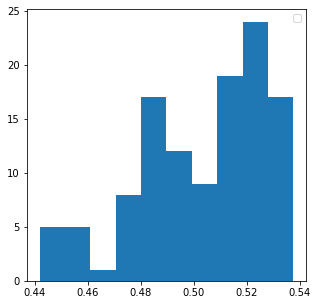

In [20]:
plt.figure(figsize=(5, 5))
plt.hist(submission["MGMT_value_x"])
plt.legend()

In [21]:
submission

,BraTS21ID,MGMT_value_x,MGMT_value_y
0,107,0.490943,1
1,753,0.518397,0
2,303,0.479873,1
3,106,0.442441,1
4,171,0.468423,1
...,...,...,...
112,703,0.510690,0
113,21,0.513315,0
114,444,0.484937,0
115,95,0.525983,0


In [22]:
confMatrix = get_confusion_matrix(submission)
print(confMatrix)

rec = get_acc_recall(confMatrix)


# print(rec)

[[21, 35], [28, 33]]
Acc: 0.46153846153846156 	 Recall: 0.5409836065573771
